In [1]:
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

with open('/content/drive/MyDrive/Colab Notebooks/train_val_data/train_validate_features.pkl', 'rb') as f:
  train_validate_features = pickle.load(f)


with open('/content/drive/MyDrive/Colab Notebooks/train_val_data/train_validate_features-80-90k.pkl', 'rb') as f:
  temp_features_80_90 = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/train_val_data/train_validate_features_1.pkl', 'rb') as f:
  temp_features_1 = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/train_val_data/train_validate_features_2.pkl', 'rb') as f:
  temp_features_2 = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/train_val_data/train_validate_features_30k-50k.pkl', 'rb') as f:
  temp_features_30_50 = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/train_val_data/train_validate_features-80-90k.pkl', 'rb') as f:
  temp_features_80_90_2 = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/train_val_data/train_validate_features_50k-80k.pkl', 'rb') as f:
  temp_features_50_80 = pickle.load(f)


train_validate_features.update(temp_features_80_90)
train_validate_features.update(temp_features_1)
train_validate_features.update(temp_features_2)
train_validate_features.update(temp_features_30_50)
train_validate_features.update(temp_features_80_90_2)
train_validate_features.update(temp_features_50_80)


In [4]:
print(len(train_validate_features))

import numpy as np
first_key = list(train_validate_features.keys())[0]
print(np.array(train_validate_features[first_key]).shape)


97919
(1536,)


In [5]:
with open('/content/drive/MyDrive/Colab Notebooks/train_val_data/val_validate_images_features.pkl', 'rb') as f:
  val_validate_features = pickle.load(f)

In [6]:
with open('/content/drive/MyDrive/Colab Notebooks/train_val_data/captions_val_dict.pkl', 'rb') as f:
  captions_val_dict = pickle.load(f)


In [7]:

with open('/content/drive/MyDrive/Colab Notebooks/train_val_data/captions_train_dict.pkl', 'rb') as f:
  captions_train_dict = pickle.load(f)


In [8]:
keys_to_remove = []
for key in captions_val_dict:
  if key not in val_validate_features:
    keys_to_remove.append(key)

for key in keys_to_remove:
    del captions_val_dict[key]
    if key in val_validate_features:
        del val_validate_features[key]

print(len(captions_val_dict))
print(len(val_validate_features))


4147
4147


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model

In [10]:
# Flatten all captions across all images into a single list
all_captions = [caption for captions in captions_train_dict.values() for caption in captions]

# Fit tokenizer on all captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Get vocabulary size
vocab_len = len(tokenizer.word_index) + 1

# Get maximum caption length
max_len = max(len(caption.split()) for caption in all_captions)


In [ ]:
max_len

49

In [ ]:
vocab_len

26771

In [12]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, image_ids, captions_dict, features_dict, tokenizer, max_len, vocab_size,
                 batch_size=32, shuffle=True, max_captions_per_image=None, debug=False):
        self.image_ids = image_ids
        self.captions_dict = captions_dict
        self.features_dict = features_dict
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_captions_per_image = max_captions_per_image
        self.debug = debug

        # Filter image_ids to only include those in captions_dict and features_dict
        self.image_ids = [img_id for img_id in self.image_ids
                           if img_id in self.captions_dict and img_id in self.features_dict]

        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_ids = [self.image_ids[k] for k in batch_indexes]

        x1, x2, y = [], [], []

        for img_id in batch_image_ids:
            try: # Add try-except block to catch the KeyError
                captions = self.captions_dict[img_id]
                feature = self.features_dict[img_id]

                # Ensure feature is 1D vector
                if isinstance(feature, np.ndarray) and feature.ndim > 1:
                    feature = feature.squeeze()

                # Limit number of captions (optional)
                if self.max_captions_per_image:
                    captions = captions[:self.max_captions_per_image]

                for caption in captions:
                    seq = self.tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq = pad_sequences([seq[:i]], maxlen=self.max_len)[0]
                        out_seq = to_categorical(seq[i], num_classes=self.vocab_size)

                        x1.append(feature)
                        x2.append(in_seq)
                        y.append(out_seq)
            except KeyError:
                # If KeyError, skip the image and continue with the next one
                print(f"Skipping image {img_id} due to missing captions or features.")
                continue

        x1 = np.array(x1)
        x2 = np.array(x2)
        y = np.array(y)

        if self.debug:
            print(f"[DEBUG] Batch {index} shapes → x1: {x1.shape}, x2: {x2.shape}, y: {y.shape}")

        return (x1, x2), y

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, Concatenate,
    Bidirectional, LayerNormalization, LeakyReLU, Attention
)
from tensorflow.keras.regularizers import l2

# Image feature extractor input (4096 feature vector from VGG16)
input_1 = Input(shape=(1536,))
dense_img = Dense(256, kernel_regularizer=l2(0.001))(input_1)
dense_img = LeakyReLU(alpha=0.1)(dense_img)
dense_img = LayerNormalization()(dense_img)  # Normalize features
dense_img = Dropout(0.5)(dense_img)

# Text sequence input
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=False)(input_2)
embedding = Dropout(0.5)(embedding)

# Bidirectional LSTM with L2 regularization
lstm = Bidirectional(
    LSTM(256, return_sequences=True, recurrent_activation='sigmoid', kernel_regularizer=l2(0.001))
)(embedding)
lstm = LayerNormalization()(lstm)
lstm = Dropout(0.5)(lstm)

# Attention Mechanism
attention_layer = Attention()([lstm, lstm])
lstm_out = LSTM(256, return_sequences=False)(attention_layer)

# Concatenation of image and text features
decoder1 = Concatenate()([dense_img, lstm_out])
decoder1 = Dense(256, kernel_regularizer=l2(0.001))(decoder1)
decoder1 = LeakyReLU(alpha=0.1)(decoder1)
decoder1 = Dropout(0.5)(decoder1)

# Output layer
outputs = Dense(vocab_len, activation='softmax')(decoder1)

# Define the model
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Summarize model
print(model.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 49)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 49, 256)   │  6,853,376 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 49, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1536)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 49, 512)   │  1,050,624 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    393,472 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 512)   │      1,024 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 256)       │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 49, 512)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256)       │        512 │ leaky_re_lu_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 49, 512)   │          0 │ dropout_6[0][0],  │
│ (Attention)         │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    787,456 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 256)       │          0 │ dense_4[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 26771)     │  6,880,147 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,097,939 (61.41 MB)

 Trainable params: 16,097,939 (61.41 MB)

 Non-trainable params: 0 (0.00 B)

None


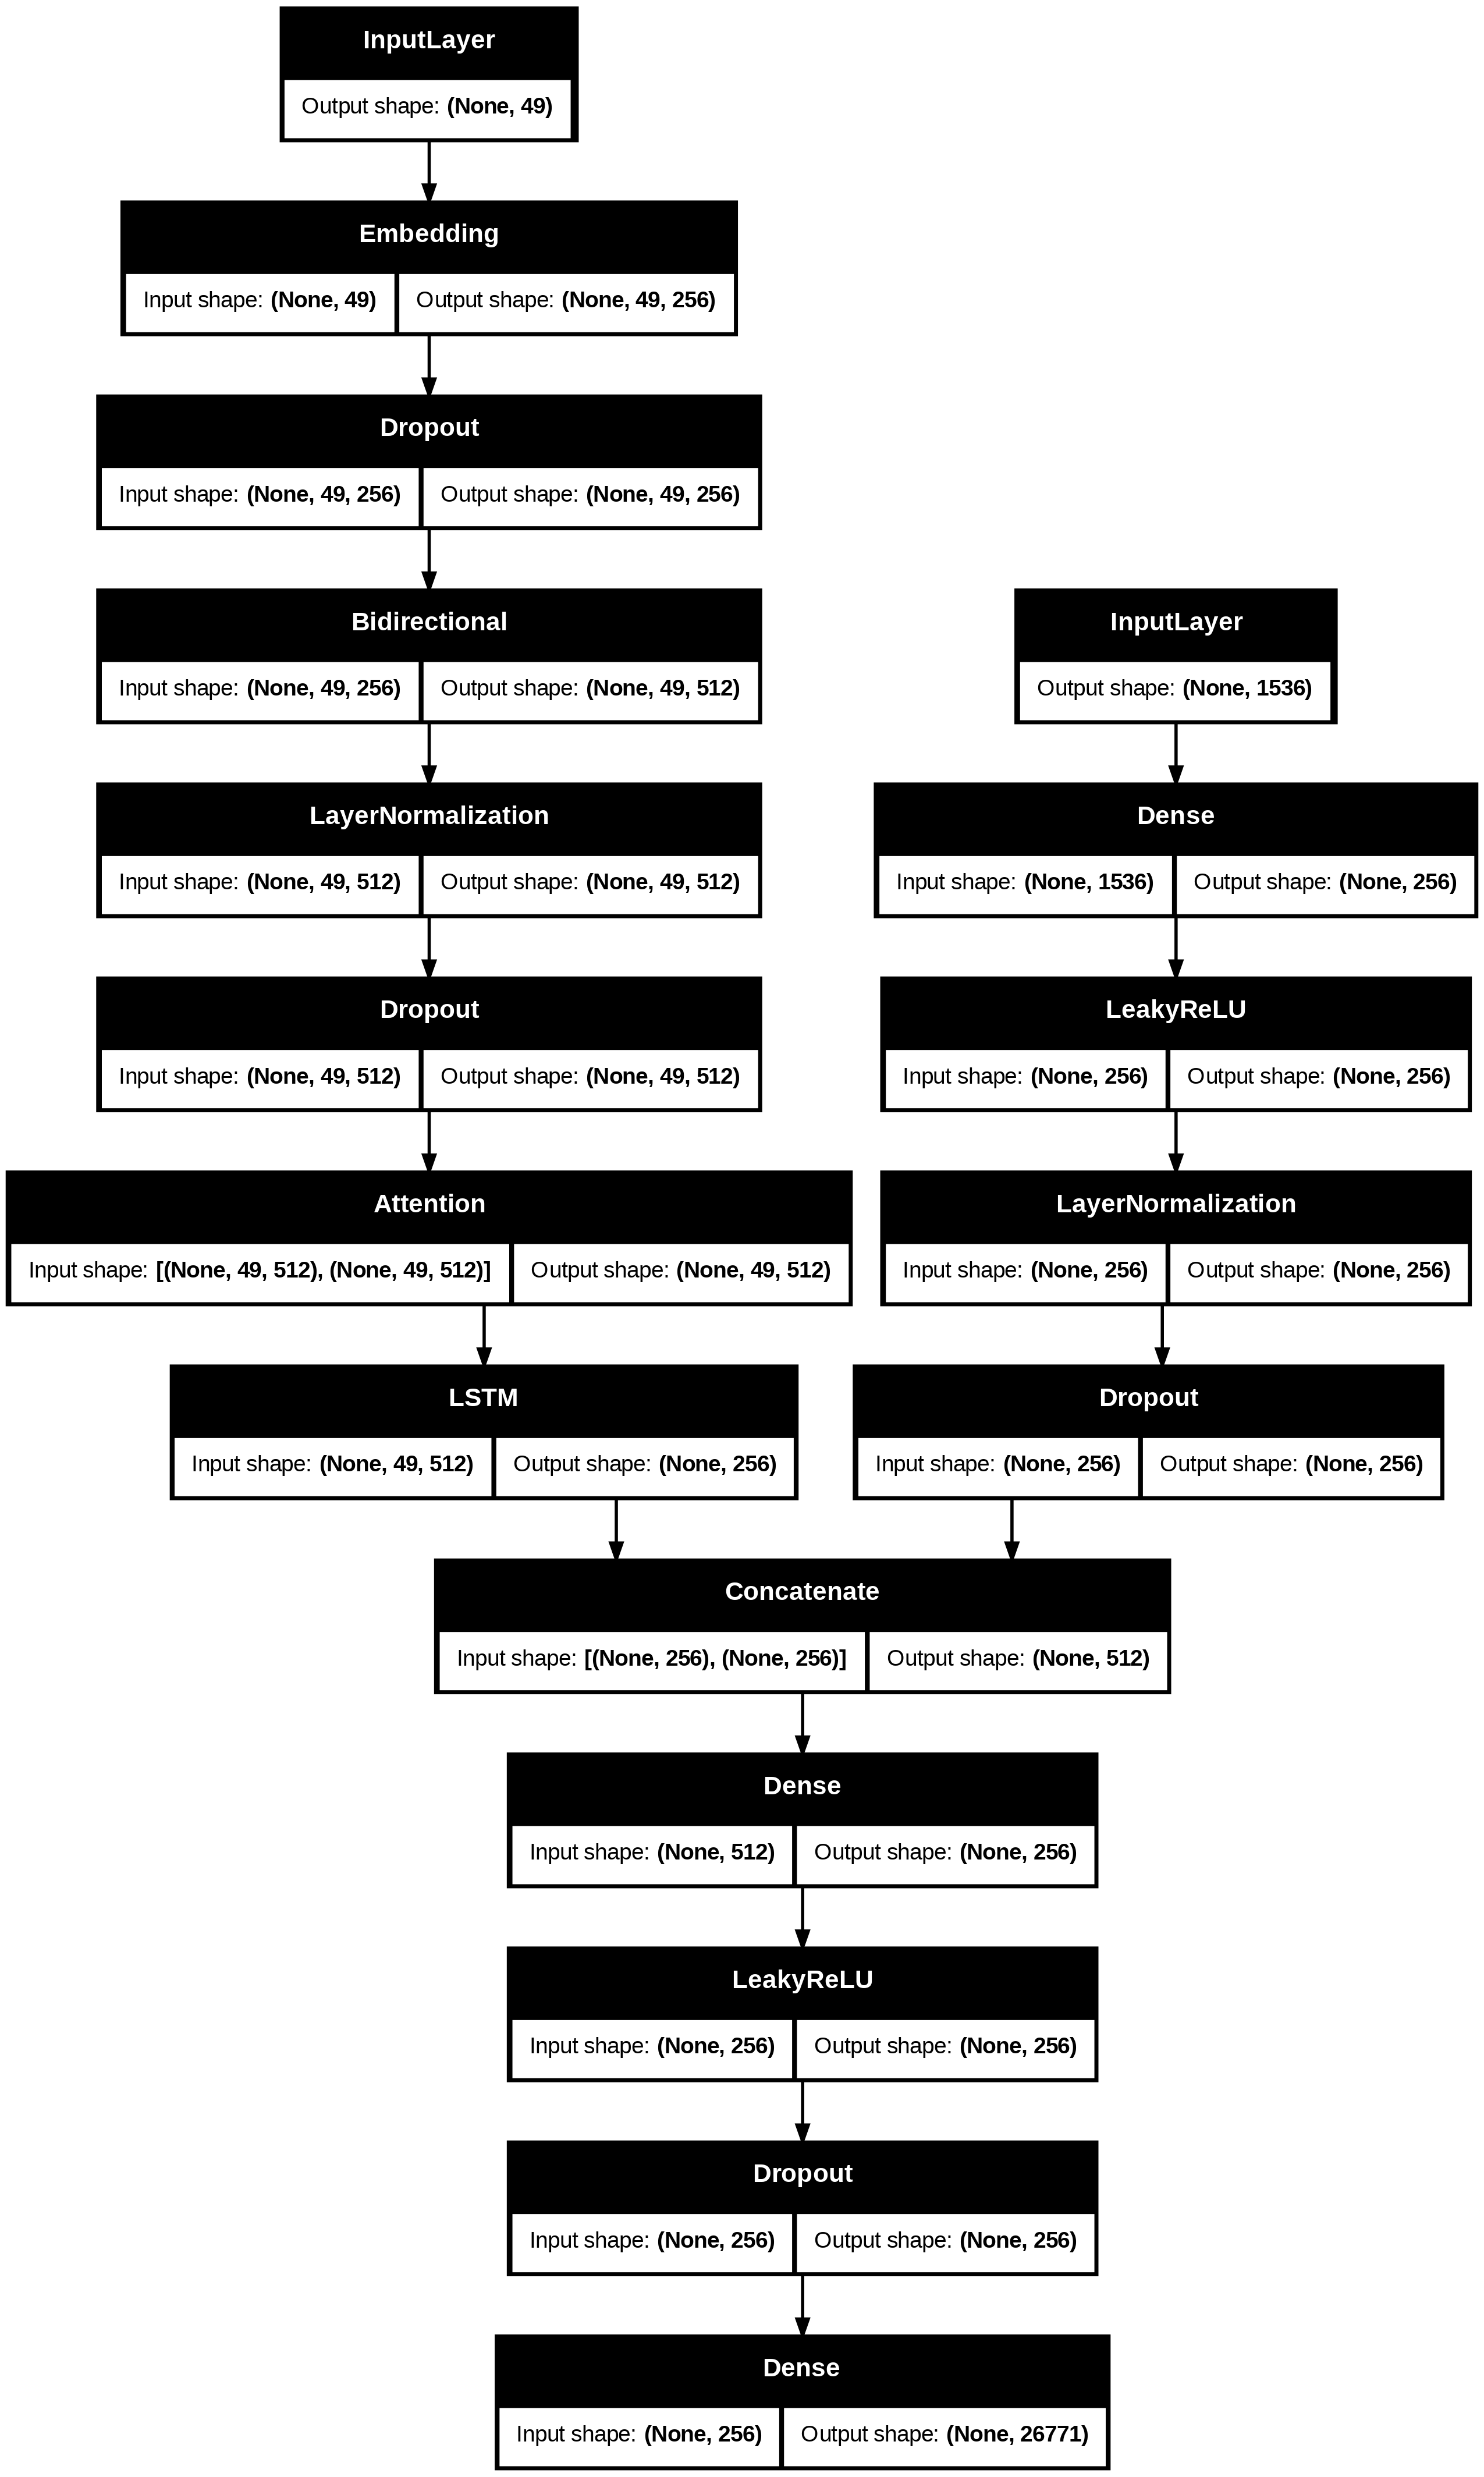

In [15]:
plot_model(model, to_file='model.png', show_shapes=True)

In [16]:
train_image_id = list(captions_train_dict.keys())
val_image_id = list(captions_val_dict.keys())
len(train_image_id), len(val_image_id)

(97919, 4147)

In [18]:
batch_size = 64
train_generator = DataGenerator(
    image_ids=train_image_id,
    captions_dict=captions_train_dict,
    features_dict=train_validate_features,
    tokenizer=tokenizer,
    max_len=max_len,
    vocab_size=vocab_len,
    batch_size=batch_size,
    shuffle=True
)

val_generator = DataGenerator(
    image_ids=val_image_id,
    captions_dict=captions_val_dict,
    features_dict=val_validate_features,
    tokenizer=tokenizer,
    max_len=max_len,
    vocab_size=vocab_len,
    batch_size=batch_size,
    shuffle=False
)


In [19]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TerminateOnNaN
)

# Save the best model during training (in Keras v3 format)
checkpoint_callback = ModelCheckpoint(
    filepath='./best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Stop training if validation loss does not improve for 5 epochs
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when a metric has stopped improving
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    cooldown=1,  # avoid too frequent LR drops
    verbose=1
)

# Log epoch-level metrics to CSV for visualization later
csv_logger_callback = CSVLogger("training_log.csv", append=True)

# Stop training immediately if NaN loss is encountered
terminate_on_nan_callback = TerminateOnNaN()


# Final callback list
callbacks = [
    checkpoint_callback,
    early_stopping_callback,
    reduce_lr_callback,
    csv_logger_callback,
    terminate_on_nan_callback,
    # bleu_callback
]


In [20]:
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.6167
Epoch 1: val_loss improved from inf to 3.72353, saving model to ./best_model.keras
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 2387s 2s/step - loss: 5.6162 - val_loss: 3.7235 - learning_rate: 0.0010
Epoch 2/3
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.8560
Epoch 2: val_loss improved from 3.72353 to 3.45212, saving model to ./best_model.keras
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 2234s 1s/step - loss: 3.8560 - val_loss: 3.4521 - learning_rate: 0.0010
Epoch 3/3
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.6397
Epoch 3: val_loss improved from 3.45212 to 3.34588, saving model to ./best_model.keras
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 2244s 1s/step - loss: 3.6397 - val_loss: 3.3459 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.
